In [1]:
!pip install  --quiet langgraph
!pip install  --quiet langchain-google-genai
!pip install --quiet langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.8/120.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.3 MB/s eta 0:00:00


In [18]:
from google.colab import userdata
import music21
import pygame
import tempfile
import random
from IPython.display import Image, display

from typing import TypedDict, Dict

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import ChatPromptTemplate

from langgraph.graph.state import CompiledStateGraph
from langgraph.graph import END, START, StateGraph

In [4]:
google_api_key = userdata.get('GOOGLE_API_KEY')
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model='gemini-1.5-flash',
                                                     api_key=google_api_key)

llm.invoke("What is 2 * 2?").content

'2 * 2 = 4 \n'

In [31]:
class MusicState(TypedDict):
  input: str
  melody: str
  harmony: str
  rhythm: str
  style: str
  composition: str
  midi_file: str

In [35]:
def melody_generator_node(state: MusicState)->Dict:
  """Graph node that generates melody based on user input"""
  prompt: str = f"""Generate a melody based on the input {state["input"]}. Represent
                it as a string of notes in music21 format
                """
  melody = llm.invoke(prompt).content
  return {"melody": melody}

def harmony_generator_node(state: MusicState)->Dict:
  """Graph node that generates harmony based on user input"""
  prompt: str = f"""Create a harmony based on the input {state["input"]}. Represent
                it as a string of chords in music21 format
                """
  harmony = llm.invoke(prompt).content
  return {"harmony": harmony}

def rhythm_generator_node(state: MusicState)->Dict:
  """Graph node that generates rhythm based on user input"""
  prompt: str = f"""Analyze and suggest rhythm for the melody {state['melody']}
                and harmony {state["harmony"]}. Represent it as string of duration
                in music21 format
                """
  rhythm = llm.invoke(prompt).content
  return {"rhythm": rhythm}

def style_adapter_node(state: MusicState)->Dict:
  """Graph node that adapts style based on user input"""
  prompt: str = f"""Adapt this composition to the style {state["style"]}, melody {state["melody"]}
                , harmony {state["harmony"]} and rhythm {state["rhythm"]}. Provide the
                result in music21 format
                """
  style = llm.invoke(prompt).content
  return {"composition": style}

def midi_converter(state: MusicState) -> Dict:
    """Convert the composition to MIDI format and save it as a file."""
    # Create a new stream
    piece = music21.stream.Score()

    # Add the composition description to the stream as a text expression
    description = music21.expressions.TextExpression(state["composition"])
    piece.append(description)

    # Define a wide variety of scales and chords
    scales = {
        'C major': ['C', 'D', 'E', 'F', 'G', 'A', 'B'],
        'C minor': ['C', 'D', 'Eb', 'F', 'G', 'Ab', 'Bb'],
        'C harmonic minor': ['C', 'D', 'Eb', 'F', 'G', 'Ab', 'B'],
        'C melodic minor': ['C', 'D', 'Eb', 'F', 'G', 'A', 'B'],
        'C dorian': ['C', 'D', 'Eb', 'F', 'G', 'A', 'Bb'],
        'C phrygian': ['C', 'Db', 'Eb', 'F', 'G', 'Ab', 'Bb'],
        'C lydian': ['C', 'D', 'E', 'F#', 'G', 'A', 'B'],
        'C mixolydian': ['C', 'D', 'E', 'F', 'G', 'A', 'Bb'],
        'C locrian': ['C', 'Db', 'Eb', 'F', 'Gb', 'Ab', 'Bb'],
        'C whole tone': ['C', 'D', 'E', 'F#', 'G#', 'A#'],
        'C diminished': ['C', 'D', 'Eb', 'F', 'Gb', 'Ab', 'A', 'B'],
    }

    chords = {
        'C major': ['C4', 'E4', 'G4'],
        'C minor': ['C4', 'Eb4', 'G4'],
        'C diminished': ['C4', 'Eb4', 'Gb4'],
        'C augmented': ['C4', 'E4', 'G#4'],
        'C dominant 7th': ['C4', 'E4', 'G4', 'Bb4'],
        'C major 7th': ['C4', 'E4', 'G4', 'B4'],
        'C minor 7th': ['C4', 'Eb4', 'G4', 'Bb4'],
        'C half-diminished 7th': ['C4', 'Eb4', 'Gb4', 'Bb4'],
        'C fully diminished 7th': ['C4', 'Eb4', 'Gb4', 'A4'],
    }

    def create_melody(scale_name, duration):
        """Create a melody based on a given scale."""
        melody = music21.stream.Part()
        scale = scales[scale_name]
        for _ in range(duration):
            note = music21.note.Note(random.choice(scale) + '4')
            note.quarterLength = 1
            melody.append(note)
        return melody

    def create_chord_progression(duration):
        """Create a chord progression."""
        harmony = music21.stream.Part()
        for _ in range(duration):
            chord_name = random.choice(list(chords.keys()))
            chord = music21.chord.Chord(chords[chord_name])
            chord.quarterLength = 1
            harmony.append(chord)
        return harmony

    # Parse the user input to determine scale and style
    user_input = state['input'].lower()
    if 'minor' in user_input:
        scale_name = 'C minor'
    elif 'major' in user_input:
        scale_name = 'C major'
    else:
        scale_name = random.choice(list(scales.keys()))

    # Create a 7-second piece (7 beats at 60 BPM)
    melody = create_melody(scale_name, 7)
    harmony = create_chord_progression(7)

    # Add a final whole note to make it exactly 8 beats (7 seconds at 60 BPM)
    final_note = music21.note.Note(scales[scale_name][0] + '4')
    final_note.quarterLength = 1
    melody.append(final_note)

    final_chord = music21.chord.Chord(chords[scale_name.split()[0] + ' ' + scale_name.split()[1]])
    final_chord.quarterLength = 1
    harmony.append(final_chord)

    # Add the melody and harmony to the piece
    piece.append(melody)
    piece.append(harmony)

    # Set the tempo to 60 BPM
    piece.insert(0, music21.tempo.MetronomeMark(number=60))

    # Create a temporary MIDI file
    with tempfile.NamedTemporaryFile(delete=False, suffix='.mid') as temp_midi:
        piece.write('midi', temp_midi.name)

    return {"midi_file": temp_midi.name}

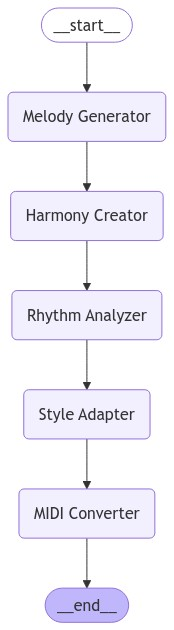

In [36]:
builder: StateGraph = StateGraph(MusicState)

builder.add_node("Melody Generator", melody_generator_node)
builder.add_node("Harmony Creator", harmony_generator_node)
builder.add_node("Rhythm Analyzer", rhythm_generator_node)
builder.add_node("Style Adapter", style_adapter_node)
builder.add_node("MIDI Converter", midi_converter)

builder.add_edge(START, "Melody Generator")
builder.add_edge("Melody Generator", "Harmony Creator")
builder.add_edge("Harmony Creator", "Rhythm Analyzer")
builder.add_edge("Rhythm Analyzer", "Style Adapter")
builder.add_edge("Style Adapter", 'MIDI Converter')
builder.add_edge('MIDI Converter', END)

agent: CompiledStateGraph = builder.compile()
display(Image(agent.get_graph().draw_mermaid_png()))

In [37]:
inputs = {
    "input": "Create a happy piano piece in C major",
    "style": "Romantic era"
}

# Invoke the workflow
result = agent.invoke(inputs)

print("Composition created")
print(f"MIDI file saved at: {result['midi_file']}")

Composition created
MIDI file saved at: /tmp/tmpx83fqhvj.mid


In [38]:
def play_midi(midi_file_path):
    """Play the generated MIDI file."""
    pygame.mixer.init()
    pygame.mixer.music.load(midi_file_path)
    pygame.mixer.music.play()

    # Wait for playback to finish
    while pygame.mixer.music.get_busy():
        pygame.time.Clock().tick(10)

    # Clean up
    pygame.mixer.quit()


print("To create and play a melody, run the following in a new cell:")
print("play_midi(result['midi_file'])")

To create and play a melody, run the following in a new cell:
play_midi(result['midi_file'])
